# The Hype Paradox: Analyzing the 2024-2025 TV Landscape
**Goal:** Quantifying the relationship between marketing reach (YouTube) and critical reception (TMDB).

**Author:** Sarim Rizvi

In [ ]:
# Importing required libraries

import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import requests
from googleapiclient.discovery import build
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import os
from dotenv import load_dotenv
from dotenv import find_dotenv

import json

# Initialize NLP
import nltk
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

In [ ]:
# Loading API Keys
env_path = find_dotenv()
load_dotenv(env_path)

TMDB_API_KEY = os.getenv('TMDB_API_KEY')
YOUTUBE_API_KEY = os.getenv('YOUTUBE_API_KEY')

if not TMDB_API_KEY or not YOUTUBE_API_KEY:
    print("Error: API keys not found. Check your .env file.")
else:
    print("API keys loaded successfully.")

API keys loaded successfully.


### TMDB API Integration

In [ ]:
""" Function to get list of shows from TMDB"""

def get_top_shows_by_page(api_key, page_num):
    url = "https://api.themoviedb.org/3/discover/tv"
    
    # Parameters to get shows from last two years, sorted by popularity
    params = {
        'api_key': api_key,
        'language': 'en-US',
        'with_original_language': 'en',
        'sort_by': 'popularity.desc',
        'first_air_date.gte': '2024-01-01',
        'first_air_date.lte': '2025-12-31',
        'page': page_num,
        'include_null_first_air_dates': 'false'
    }
    
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        shows = data['results']
        
        show_list = []
        for show in shows:
            show_list.append({
                'show_id': show['id'],
                'name': show['name'],
                'release_date': show['first_air_date'],
                'popularity': show['popularity'],
                'vote_average': show['vote_average'],
                'vote_count': show['vote_count'],
                'genre_id':show['genre_ids']
            })
            
        return pd.DataFrame(show_list)
    else:
        print(f"Error: {response.status_code}")
        return None

In [6]:
df_shows = pd.DataFrame()
for page_num in range(1, 11):
    page_data = get_top_shows_by_page(TMDB_API_KEY, page_num)
    df_shows = pd.concat([df_shows, page_data], ignore_index=True)
df_shows.head()

,show_id,name,release_date,popularity,vote_average,vote_count,genre_id
0,106379,Fallout,2024-04-10,188.2399,8.144,2501,"[10759, 10765]"
1,240459,Spartacus: House of Ashur,2025-12-05,117.1965,6.400,152,"[18, 10759]"
2,250307,The Pitt,2025-01-09,63.6929,8.700,444,[18]
3,157741,Landman,2024-11-17,58.9919,8.041,413,[18]
4,200875,IT: Welcome to Derry,2025-10-26,52.6063,8.237,1257,"[18, 9648]"


In [7]:
df_shows.shape

(200, 7)

In [8]:
df_shows.describe()

,show_id,popularity,vote_average,vote_count
count,200.000000,200.000000,200.00000,200.000000
mean,225647.475000,12.742503,7.17309,234.345000
std,47257.166719,17.282287,0.97521,328.129304
min,46518.000000,5.223300,0.00000,0.000000
25%,212776.250000,6.529950,6.78875,53.000000
50%,241396.500000,8.222550,7.25100,120.000000
75%,252330.250000,11.553700,7.74500,284.750000
max,309280.000000,188.239900,9.28600,2501.000000


In [ ]:
''' Function to get the network name of the show'''
def get_network_name(show_id, api_key):
    url = f"https://api.themoviedb.org/3/tv/{show_id}"
    params = {'api_key': api_key}
    response = requests.get(url, params=params).json()
    
    # Get the first network in the list (e.g., 'Netflix', 'HBO', 'Amazon Prime')
    if response.get('networks'):
        return response['networks'][0]['name']
    return ""

In [ ]:
# Append network information to the dataframe
df_shows['network'] = df_shows['show_id'].apply(lambda x: get_network_name(x, TMDB_API_KEY))
df_shows.head()

,show_id,name,release_date,popularity,vote_average,vote_count,genre_id,network
0,106379,Fallout,2024-04-10,188.2399,8.144,2501,"[10759, 10765]",Prime Video
1,240459,Spartacus: House of Ashur,2025-12-05,117.1965,6.400,152,"[18, 10759]",STARZ
2,250307,The Pitt,2025-01-09,63.6929,8.700,444,[18],Max
3,157741,Landman,2024-11-17,58.9919,8.041,413,[18],Paramount+
4,200875,IT: Welcome to Derry,2025-10-26,52.6063,8.237,1257,"[18, 9648]",HBO


In [16]:
''' Function to get genre mapping from TMDB'''
def get_genre_map(api_key):
    url = f"https://api.themoviedb.org/3/genre/tv/list?api_key={api_key}&language=en-US"
    response = requests.get(url).json()
    # Create a dictionary: {18: 'Drama', 10765: 'Sci-Fi & Fantasy', ...}
    return {genre['id']: genre['name'] for genre in response['genres']}
genre_map = get_genre_map(TMDB_API_KEY)
genre_map

{10759: 'Action & Adventure',
 16: 'Animation',
 35: 'Comedy',
 80: 'Crime',
 99: 'Documentary',
 18: 'Drama',
 10751: 'Family',
 10762: 'Kids',
 9648: 'Mystery',
 10763: 'News',
 10764: 'Reality',
 10765: 'Sci-Fi & Fantasy',
 10766: 'Soap',
 10767: 'Talk',
 10768: 'War & Politics',
 37: 'Western'}

In [ ]:
'''Function to get the primary genre of a show'''
def map_primary_genre(ids, mapping):
    if isinstance(ids, list) and len(ids) > 0:
        # Take the first ID in the list
        primary_id = ids[0]
        return mapping.get(primary_id, "Unknown")
    return "Unknown"

'''Function to get the secondary genre of a show'''
def map_secondary_genre(ids, mapping):
    if isinstance(ids, list) and len(ids) > 1:
        # Take the second ID in the list
        secondary_id = ids[1]
        return mapping.get(secondary_id, "None")
    return "None"

In [ ]:
# Append genre information to the dataframe
df_shows['primary_genre'] = df_shows['genre_id'].apply(lambda x: map_primary_genre(x, genre_map))
df_shows['secondary_genre'] = df_shows['genre_id'].apply(lambda x: map_secondary_genre(x, genre_map))

print(df_shows[['name', 'genre_id', 'primary_genre', 'secondary_genre']].head())

                        name        genre_id       primary_genre  \
0                    Fallout  [10759, 10765]  Action & Adventure   
1  Spartacus: House of Ashur     [18, 10759]               Drama   
2                   The Pitt            [18]               Drama   
3                    Landman            [18]               Drama   
4       IT: Welcome to Derry      [18, 9648]               Drama   

      secondary_genre  
0    Sci-Fi & Fantasy  
1  Action & Adventure  
2                None  
3                None  
4             Mystery  


In [ ]:
# Genre-wise distribution of shows
df_shows.groupby(['primary_genre'])['show_id'].count()

primary_genre
Action & Adventure    16
Animation             18
Comedy                24
Crime                 18
Documentary            3
Drama                 88
Mystery                7
News                   1
Reality                4
Sci-Fi & Fantasy      16
Soap                   2
Talk                   1
Unknown                1
Western                1
Name: show_id, dtype: int64

### Data Preprocessing

In [17]:
# Selecting shows with atleast 20 votes
df_shows = df_shows[df_shows.vote_count > 20]
all_shows = df_shows.copy()
all_shows = all_shows.reset_index(drop=True)
all_shows.release_date = pd.to_datetime(all_shows.release_date)

all_shows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   show_id          182 non-null    int64         
 1   name             182 non-null    object        
 2   release_date     182 non-null    datetime64[ns]
 3   popularity       182 non-null    float64       
 4   vote_average     182 non-null    float64       
 5   vote_count       182 non-null    int64         
 6   genre_id         182 non-null    object        
 7   network          182 non-null    object        
 8   primary_genre    182 non-null    object        
 9   secondary_genre  182 non-null    object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 14.3+ KB


In [18]:
all_shows.head()

,show_id,name,release_date,popularity,vote_average,vote_count,genre_id,network,primary_genre,secondary_genre
0,106379,Fallout,2024-04-10,188.2399,8.144,2501,"[10759, 10765]",Prime Video,Action & Adventure,Sci-Fi & Fantasy
1,240459,Spartacus: House of Ashur,2025-12-05,117.1965,6.400,152,"[18, 10759]",STARZ,Drama,Action & Adventure
2,250307,The Pitt,2025-01-09,63.6929,8.700,444,[18],Max,Drama,None
3,157741,Landman,2024-11-17,58.9919,8.041,413,[18],Paramount+,Drama,None
4,200875,IT: Welcome to Derry,2025-10-26,52.6063,8.237,1257,"[18, 9648]",HBO,Drama,Mystery


### Network and Genre Analysis

In [29]:
all_shows['network'] = (
    all_shows['network']
    .str.replace('Paramount+ with Showtime', 'Paramount+')
    .str.strip()
)

In [30]:
# Grouping by network
network_stats = all_shows.groupby('network').agg({
    'vote_average': 'mean',
    'popularity': 'mean',
    'show_id': 'count'
}).rename(columns={'show_id': 'show_count'})

# Filter for networks with at least 3 shows to avoid 'one-hit wonder' bias
network_stats = network_stats[network_stats['show_count'] >= 3].sort_values(by='vote_average', ascending=False)

print(network_stats)

             vote_average  popularity  show_count
network                                          
Adult Swim       8.131000    9.085600           3
Paramount+       7.681333   17.623789           9
Prime Video      7.355300   19.766490          20
Max              7.290250   21.232775           4
Netflix          7.263829    8.569659          41
HBO              7.232857   15.815043           7
Peacock          7.204000   10.205080           5
FX               7.169500   13.632750           4
ABC              7.156750   19.946375           4
Apple TV         7.138381   10.415929          21
Hulu             7.059200    8.838770          10
NBC              6.964500   10.488275           4
Disney+          6.880727   10.032782          11
BBC One          6.877667   12.294067           3
CBS              6.814500   14.184450           8
FOX              6.774667    9.193433           3


In [ ]:
# Calculate Efficiency Score
network_stats['efficiency_score'] = network_stats['vote_average'] / np.log(network_stats['popularity'])

# Sort by Efficiency to see the 'Quality Leaders'
network_stats_sorted = network_stats.sort_values(by='efficiency_score', ascending=False)
print(network_stats_sorted[['vote_average', 'popularity', 'efficiency_score']])

             vote_average  popularity  efficiency_score
network                                                
Adult Swim       8.131000    9.085600          3.684703
Netflix          7.263829    8.569659          3.381312
Hulu             7.059200    8.838770          3.239432
Peacock          7.204000   10.205080          3.101315
FOX              6.774667    9.193433          3.053729
Apple TV         7.138381   10.415929          3.046247
Disney+          6.880727   10.032782          2.984020
NBC              6.964500   10.488275          2.963292
FX               7.169500   13.632750          2.744332
BBC One          6.877667   12.294067          2.741071
Paramount+       7.681333   17.623789          2.677123
HBO              7.232857   15.815043          2.619688
CBS              6.814500   14.184450          2.569428
Prime Video      7.355300   19.766490          2.464923
ABC              7.156750   19.946375          2.391125
Max              7.290250   21.232775          2

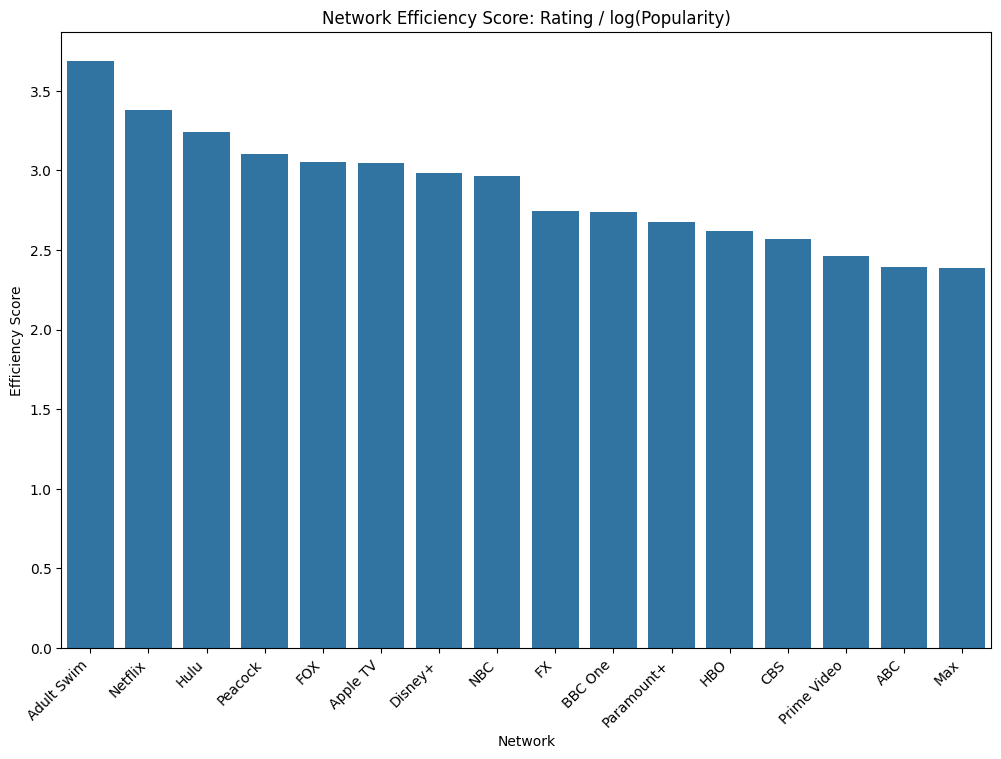

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x=network_stats_sorted.index, y='efficiency_score', data=network_stats_sorted)
plt.xticks(rotation=45, ha='right')
plt.title('Network Efficiency Score: Rating / log(Popularity)')
plt.ylabel('Efficiency Score')
plt.xlabel('Network')
plt.show()

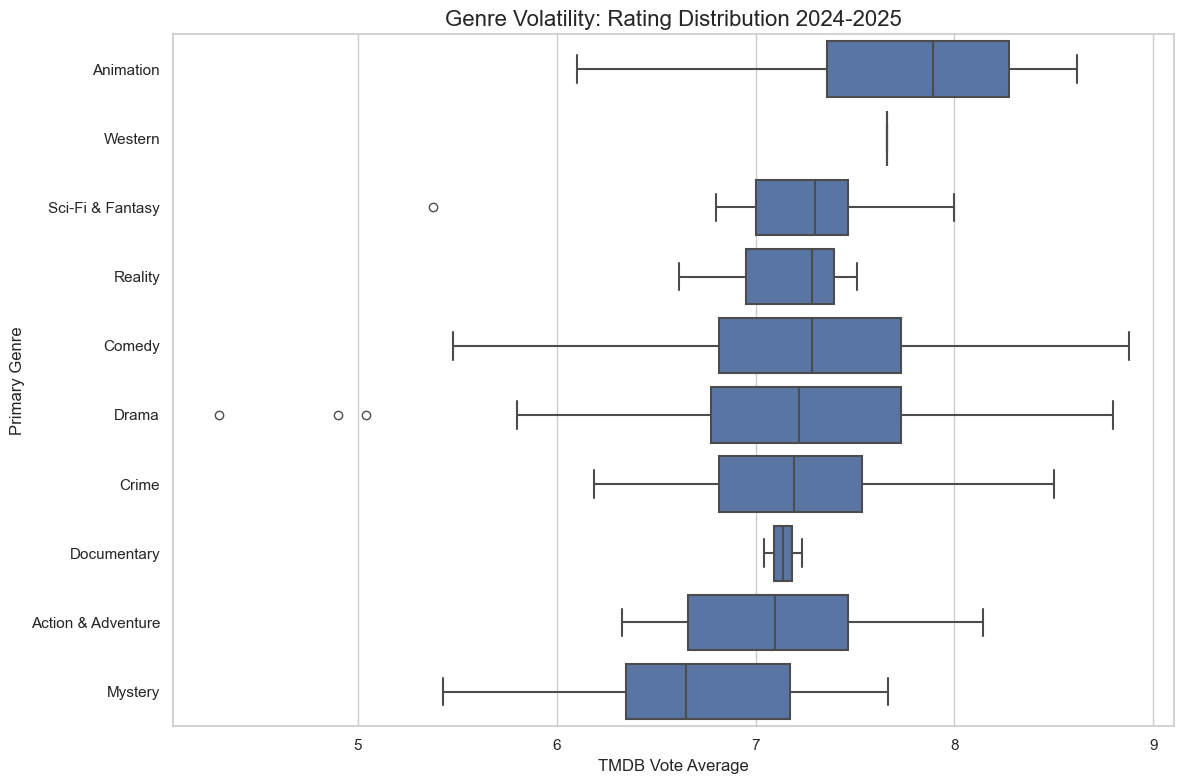

In [ ]:
genre_order = all_shows.groupby('primary_genre')['vote_average'].median().sort_values(ascending=False).index

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

sns.boxplot(
    data=all_shows, 
    x='vote_average', 
    y='primary_genre', 
    order=genre_order, 
    linewidth=1.5
)

plt.title('Genre Volatility: Rating Distribution 2024-2025', fontsize=16)
plt.xlabel('TMDB Vote Average', fontsize=12)
plt.ylabel('Primary Genre', fontsize=12)

plt.tight_layout()
plt.savefig('genre_volatility.png')
plt.show()

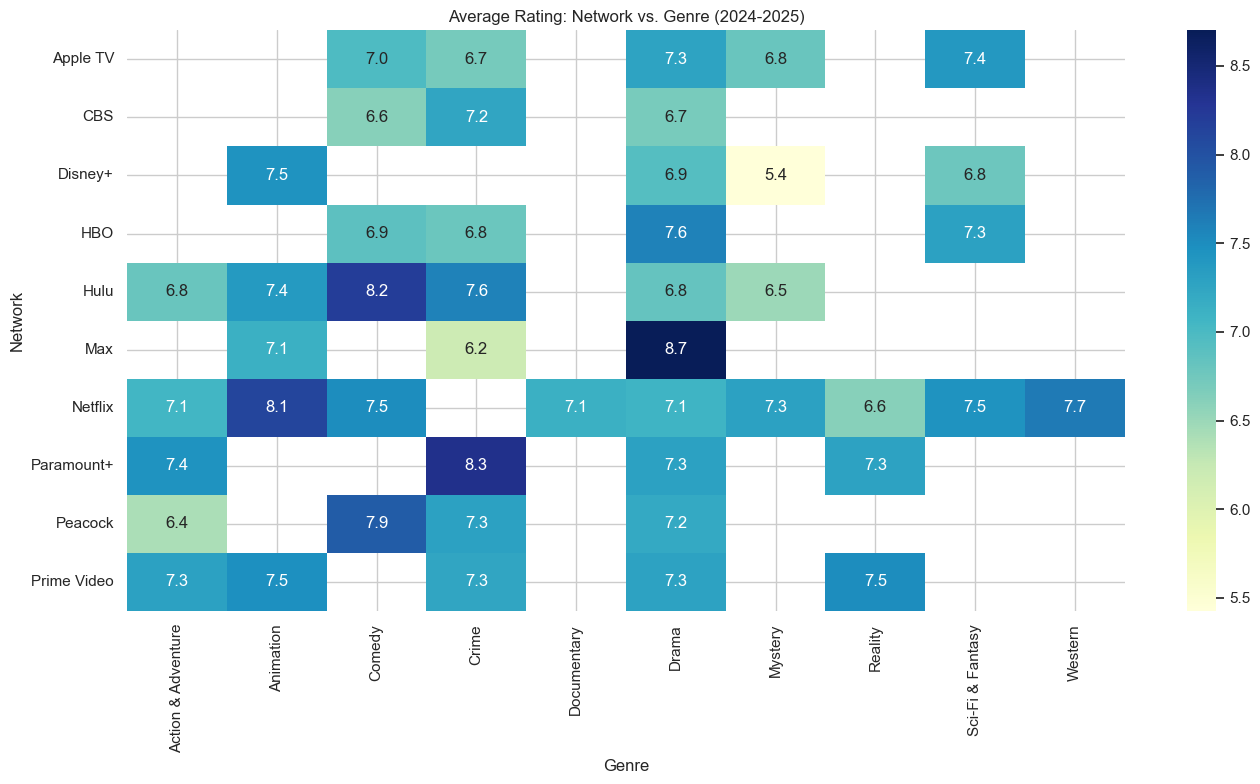

In [ ]:
# Create a Pivot Table for the Heatmap
top_networks = all_shows['network'].value_counts().nlargest(10).index
df_heatmap = all_shows[all_shows['network'].isin(top_networks)]

pivot_table = df_heatmap.pivot_table(
    values='vote_average', 
    index='network', 
    columns='primary_genre', 
    aggfunc='mean'
)

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt=".1f")
plt.title('Average Rating: Network vs. Genre (2024-2025)')
plt.ylabel('Network')
plt.xlabel('Genre')
plt.tight_layout()
plt.savefig('nw_genre.png')
plt.show()

In [100]:
# Hidden gems
hidden_gems = all_shows[(all_shows.popularity < 15) & (all_shows.vote_average > 8)].copy()
hidden_gems = hidden_gems.sort_values(by='vote_average', ascending=False)
hidden_gems.head()

,show_id,name,release_date,popularity,vote_average,vote_count,genre_id,network,primary_genre,secondary_genre
95,245026,Wizards Beyond Waverly Place,2024-10-29,9.1018,8.876,173,"[35, 10765, 10751]",Disney Channel,Comedy,Sci-Fi & Fantasy
94,207484,Outlander: Blood of My Blood,2025-08-08,9.1150,8.629,70,[18],STARZ,Drama,None
44,138502,X-Men '97,2024-03-20,14.2792,8.529,622,"[16, 10759, 10765]",Disney+,Animation,Action & Adventure
45,259909,Dexter: Resurrection,2025-07-13,14.0756,8.503,393,"[80, 18, 9648]",Paramount+ with Showtime,Crime,Drama
113,228878,Common Side Effects,2025-02-02,8.4848,8.400,230,"[16, 18, 35, 10765]",Adult Swim,Animation,Drama


In [43]:
all_shows.drop('hype_gap', axis=1, inplace=True)

In [39]:
'''Function to get cast details'''
def get_cast_members(api_key, series_id):
    # Using aggregate_credits for better TV data
    url = f"https://api.themoviedb.org/3/tv/{series_id}/aggregate_credits?api_key={api_key}"
    response = requests.get(url)
    
    if response.status_code == 200:
        cast = response.json().get('cast', [])
        # Get top 3 actors by total episode count
        top_cast = [person.get('name') for person in cast[:3]]
        return ", ".join(top_cast)
    return "Unknown"

all_shows['top_cast'] = all_shows['show_id'].apply(lambda x: get_cast_members(TMDB_API_KEY, x))
all_shows.head()

,show_id,name,release_date,popularity,vote_average,vote_count,genre_id,network,primary_genre,secondary_genre,top_cast
0,106379,Fallout,2024-04-10,188.2399,8.144,2501,"[10759, 10765]",Prime Video,Action & Adventure,Sci-Fi & Fantasy,"Ella Purnell, Aaron Moten, Moisés Arias"
1,240459,Spartacus: House of Ashur,2025-12-05,117.1965,6.400,152,"[18, 10759]",STARZ,Drama,Action & Adventure,"Nick E. Tarabay, Graham McTavish, Tenika Davis"
2,250307,The Pitt,2025-01-09,63.6929,8.700,444,[18],Max,Drama,None,"Noah Wyle, Patrick Ball, Katherine LaNasa"
3,157741,Landman,2024-11-17,58.9919,8.041,413,[18],Paramount+,Drama,None,"Billy Bob Thornton, Demi Moore, Ali Larter"
4,200875,IT: Welcome to Derry,2025-10-26,52.6063,8.237,1257,"[18, 9648]",HBO,Drama,Mystery,"Taylour Paige, Jovan Adepo, Matilda Lawler"


In [44]:
'''Function to get the sum of a show's cast previous credits'''
def get_ensemble_legacy_score(api_key, series_id, release_year):
    # 1. Fetch Aggregate Credits (shows top cast by importance)
    url = f"https://api.themoviedb.org/3/tv/{series_id}/aggregate_credits?api_key={api_key}"
    res = requests.get(url).json()
    cast = res.get('cast', [])[:3] # Get Top 3 actors
    
    total_ensemble_score = 0
    actors_found = []

    for actor in cast:
        actor_id = actor.get('id')
        actors_found.append(actor.get('name'))
        
        # 2. Get actor's history
        h_url = f"https://api.themoviedb.org/3/person/{actor_id}/combined_credits?api_key={api_key}"
        history = requests.get(h_url).json().get('cast', [])
        
        # 3. Filter for 'Significant' past credits (Top 3 billing + Before release_year)
        sig_credits = [
            c for c in history 
            if c.get('order', 10) < 5 # Was a lead/major supporting role
            and c.get('release_date', '9999')[:4] < str(release_year)
        ]
        total_ensemble_score += len(sig_credits)
        
    return total_ensemble_score

In [45]:
import time
from tqdm import tqdm

# Loop through your 200 shows with a progress bar
legacy_data = []
for idx, row in tqdm(all_shows.iterrows(), total=len(all_shows)):
    
    current_id = row['show_id']
    score = get_ensemble_legacy_score(TMDB_API_KEY, current_id, row['release_date'].year)
    legacy_data.append({
        'show_id': current_id, # This is our anchor!
        'pre_existing_credits': score
    })
    
    # Small delay to be safe with rate limits
    if idx % 40 == 0: time.sleep(1)

df_legacy = pd.DataFrame(legacy_data)

all_shows = pd.merge(all_shows, df_legacy, on='show_id', how='left')
all_shows.head()

  0%|          | 0/182 [00:00<?, ?it/s]

100%|██████████| 182/182 [01:44<00:00,  1.74it/s]


,show_id,name,release_date,popularity,vote_average,vote_count,genre_id,network,primary_genre,secondary_genre,top_cast,pre_existing_credits
0,106379,Fallout,2024-04-10,188.2399,8.144,2501,"[10759, 10765]",Prime Video,Action & Adventure,Sci-Fi & Fantasy,"Ella Purnell, Aaron Moten, Moisés Arias",40
1,240459,Spartacus: House of Ashur,2025-12-05,117.1965,6.400,152,"[18, 10759]",STARZ,Drama,Action & Adventure,"Nick E. Tarabay, Graham McTavish, Tenika Davis",40
2,250307,The Pitt,2025-01-09,63.6929,8.700,444,[18],Max,Drama,None,"Noah Wyle, Patrick Ball, Katherine LaNasa",19
3,157741,Landman,2024-11-17,58.9919,8.041,413,[18],Paramount+,Drama,None,"Billy Bob Thornton, Demi Moore, Ali Larter",128
4,200875,IT: Welcome to Derry,2025-10-26,52.6063,8.237,1257,"[18, 9648]",HBO,Drama,Mystery,"Taylour Paige, Jovan Adepo, Matilda Lawler",21


In [ ]:
# Selecting the top 100 shows for YouTube comment analysis
top_100_shows = all_shows[:100]
top_100_shows.shape

(100, 13)

### YouTube API Integration

In [ ]:
"""Function to find the best trailer match and return the video ID."""
def get_trailer_video_id(show_name, network_name, release_date, youtube):
    release_dt = datetime.strptime(release_date, '%Y-%m-%d')
    start_date = (release_dt - timedelta(days=365)).isoformat() + "Z"
    end_date = (release_dt + timedelta(days=30)).isoformat() + "Z"

    query = f"{show_name} Official Trailer {network_name}"
    
    search_res = youtube.search().list(
        q=query, part='snippet',
        publishedAfter=start_date, publishedBefore=end_date,
        maxResults=1, type='video'
    ).execute()
    
    if not search_res['items']:
        return None
    return search_res['items'][0]['id']['videoId']

In [ ]:
'''Function to get video statistics'''
def get_batch_stats(video_ids, youtube):
    if not video_ids: return []
    
    ids_string = ",".join(video_ids)
    
    # Try the request up to 3 times if it fails
    for attempt in range(3):
        try:
            stats_res = youtube.videos().list(
                id=ids_string,
                part='statistics'
            ).execute()
            
            batch_results = []
            for item in stats_res.get('items', []):
                batch_results.append({
                    'video_id': item['id'],
                    'yt_views': int(item['statistics'].get('viewCount', 0)),
                    'yt_likes': int(item['statistics'].get('likeCount', 0)),
                    'yt_comments': int(item['statistics'].get('commentCount', 0))
                })
            return batch_results
            
        except (ConnectionAbortedError, Exception) as e:
            print(f"Attempt {attempt + 1} failed: {e}. Retrying in 2 seconds...")
            time.sleep(2)
            
    return [] # Return empty if all 3 attempts fail

In [ ]:
'''Function to get comments of a youtube video'''
def get_comments(video_id, youtube, max_results=20):
    try:
        res = youtube.commentThreads().list(
            part='snippet', videoId=video_id,
            maxResults=max_results, textFormat='plainText'
        ).execute()
        return [item['snippet']['topLevelComment']['snippet']['textDisplay'] for item in res.get('items', [])]
    except:
        return []

In [128]:
top_100_shows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   show_id               100 non-null    int64         
 1   name                  100 non-null    object        
 2   release_date          100 non-null    datetime64[ns]
 3   popularity            100 non-null    float64       
 4   vote_average          100 non-null    float64       
 5   vote_count            100 non-null    int64         
 6   genre_id              100 non-null    object        
 7   network               100 non-null    object        
 8   primary_genre         100 non-null    object        
 9   secondary_genre       100 non-null    object        
 10  hype_gap              100 non-null    float64       
 11  top_cast              100 non-null    object        
 12  pre_existing_credits  100 non-null    int64         
dtypes: datetime64[ns](1),

In [ ]:
df_master = top_100_shows.copy()
df_master['video_id'] = None

youtube = build('youtube', 'v3', developerKey=YOUTUBE_API_KEY)

for idx, row in df_master.head(95).iterrows():
    if pd.isna(row.get('video_id')):
        formatted_date = row['release_date'].strftime('%Y-%m-%d')
        vid_id = get_trailer_video_id(row['name'], row['network'], formatted_date, youtube)
        df_master.at[idx, 'video_id'] = vid_id

df_master.head()

,show_id,name,release_date,popularity,vote_average,vote_count,genre_id,network,primary_genre,secondary_genre,hype_gap,top_cast,pre_existing_credits,video_id
0,240459,Spartacus: House of Ashur,2025-12-05,149.1448,6.385,131,"[18, 10759]",STARZ,Drama,Action & Adventure,0.463356,"Nick E. Tarabay, Graham McTavish, Tenika Davis",41,09l-Vwha48c
1,106379,Fallout,2024-04-10,147.4263,8.153,2403,"[10759, 10765]",Prime Video,Action & Adventure,Sci-Fi & Fantasy,0.122457,"Ella Purnell, Aaron Moten, Moisés Arias",40,0kQ8i2FpRDk
2,157741,Landman,2024-11-17,134.6460,8.021,385,[18],Paramount+,Drama,None,0.057548,"Billy Bob Thornton, Demi Moore, Ali Larter",128,7zxh49-bsIk
3,250307,The Pitt,2025-01-09,94.7538,8.700,392,[18],Max,Drama,None,-0.348002,"Noah Wyle, Patrick Ball, Katherine LaNasa",19,ufR_08V38sQ
4,200875,IT: Welcome to Derry,2025-10-26,70.8820,8.228,1206,"[18, 9648]",HBO,Drama,Mystery,-0.427309,"Taylour Paige, Jovan Adepo, Matilda Lawler",21,oKa6u7LT0qE


In [ ]:
df_master.tail(5)

,show_id,name,release_date,popularity,vote_average,vote_count,genre_id,network,primary_genre,secondary_genre,hype_gap,top_cast,pre_existing_credits,video_id
95,245026,Wizards Beyond Waverly Place,2024-10-29,9.1018,8.876,173,"[35, 10765, 10751]",Disney Channel,Comedy,Sci-Fi & Fantasy,-0.980310,"Janice LeAnn Brown, Alkaio Thiele, Max Matenko",0,BtCBanGregI
96,219543,Creature Commandos,2024-12-05,9.0929,7.774,279,"[16, 10765, 10759]",Max,Animation,Sci-Fi & Fantasy,-0.775387,"Indira Varma, Sean Gunn, Alan Tudyk",53,0CsuJoumqAk
97,113959,Duster,2025-05-15,9.0863,6.190,63,"[80, 18]",Max,Crime,Drama,-0.480791,"Josh Holloway, Rachel Hilson, Asivak Koostachin",21,6vDuAFfmaUE
98,138501,Agatha All Along,2024-09-18,9.0801,7.476,893,"[10765, 9648]",Disney+,Sci-Fi & Fantasy,Mystery,-0.720045,"Kathryn Hahn, Joe Locke, Sasheer Zamata",40,R9pXbNz6Vbw
99,239826,Ballard,2025-07-09,8.8856,7.044,135,"[18, 80]",Prime Video,Drama,Crime,-0.641050,"Maggie Q, Courtney Taylor, John Carroll Lynch",49,9nKRJGXgK0Q


In [135]:
df_master.at[95, 'video_id'] = 'BtCBanGregI'
df_master.at[96, 'video_id'] = '0CsuJoumqAk'
df_master.at[97, 'video_id'] = '6vDuAFfmaUE'
df_master.at[98, 'video_id'] = 'R9pXbNz6Vbw'
df_master.at[99, 'video_id'] = '9nKRJGXgK0Q'

In [ ]:
all_valid_ids = df_master[df_master['video_id'].notna()]['video_id'].tolist()
stats_master_list = []

for i in range(0, len(all_valid_ids), 50):
    batch = all_valid_ids[i:i+50]
    batch_data = get_batch_stats(batch, youtube) 
    stats_master_list.extend(batch_data)

df_stats = pd.DataFrame(stats_master_list)
df_master = pd.merge(df_master, df_stats, on='video_id', how='left')

In [ ]:

df_master.to_csv('data/integrated_tv_data.csv', index=False)

In [5]:
df_master = pd.read_csv('../data/integrated_tv_data.csv')

In [6]:
df_master.shape

(100, 17)

In [7]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   show_id               100 non-null    int64  
 1   name                  100 non-null    object 
 2   release_date          100 non-null    object 
 3   popularity            100 non-null    float64
 4   vote_average          100 non-null    float64
 5   vote_count            100 non-null    int64  
 6   genre_id              100 non-null    object 
 7   network               100 non-null    object 
 8   primary_genre         100 non-null    object 
 9   secondary_genre       77 non-null     object 
 10  hype_gap              100 non-null    float64
 11  top_cast              100 non-null    object 
 12  pre_existing_credits  100 non-null    int64  
 13  video_id              100 non-null    object 
 14  yt_views              100 non-null    int64  
 15  yt_likes              10

In [ ]:
all_comments_data = []

shows_to_fetch = df_master[df_master['video_id'].notna()]

print(f"Starting collection for {len(shows_to_fetch)} videos...")

# 2. Execution Loop
for idx, row in shows_to_fetch.iterrows():
    v_id = row['video_id']
    s_name = row['name']
    
    # Use our previously defined get_comments function
    # Quota cost: 1 unit per show
    comments = get_comments(v_id, youtube, max_results=50)
    
    # Store with metadata so you can join it back later
    all_comments_data.append({
        'show_id': row['show_id'],
        'video_id': v_id,
        'show_name': s_name,
        'comments': comments
    })
    
    # Respectful pause to keep the connection stable
    time.sleep(0.2)
    
    # Progress update every 10 shows
    if len(all_comments_data) % 10 == 0:
        print(f"Collected: {len(all_comments_data)}/{len(shows_to_fetch)}")

# 3. Save to a separate JSON file
with open('data/youtube_comments_repository.json', 'w', encoding='utf-8') as f:
    json.dump(all_comments_data, f, ensure_ascii=False, indent=4)

print("Data Collection Complete! Comments saved to youtube_comments_repository.json")

Starting collection for 100 videos...


NameError: name 'get_comments' is not defined

In [8]:
# Data Cleaning

df_master[['yt_views', 'yt_likes']] = df_master[['yt_views', 'yt_likes']].replace(0, np.nan)


df_master["engagement_score"] = (df_master.yt_likes + df_master.yt_comments) / df_master.yt_views
df_master["buzz_factor"] = df_master.yt_comments / df_master.yt_likes
df_master['review_density'] = df_master.vote_count / df_master.yt_views


df_master['log_views'] = np.log10(df_master['yt_views'])

In [9]:
missing_val_count_by_col = df_master.isnull().sum()*100/df_master.shape[0]
print(missing_val_count_by_col)

show_id                  0.0
name                     0.0
release_date             0.0
popularity               0.0
vote_average             0.0
vote_count               0.0
genre_id                 0.0
network                  0.0
primary_genre            0.0
secondary_genre         23.0
hype_gap                 0.0
top_cast                 0.0
pre_existing_credits     0.0
video_id                 0.0
yt_views                 0.0
yt_likes                 1.0
yt_comments              0.0
engagement_score         1.0
buzz_factor              1.0
review_density           0.0
log_views                0.0
dtype: float64


In [10]:
df_master.secondary_genre = df_master.secondary_genre.fillna('None')

In [11]:
missing_val_info = df_master[df_master.isnull().any(axis=1)]
missing_val_info

,show_id,name,release_date,popularity,vote_average,vote_count,genre_id,network,primary_genre,secondary_genre,...,top_cast,pre_existing_credits,video_id,yt_views,yt_likes,yt_comments,engagement_score,buzz_factor,review_density,log_views
87,251597,Bookish,2025-07-16,9.7947,6.813,24,"[80, 9648, 18]",U&Alibi,Crime,Mystery,...,"Mark Gatiss, Polly Walker, Elliot Levey",94,xDnkO4GGBUM,200525,NaN,0,NaN,NaN,0.00012,5.302169


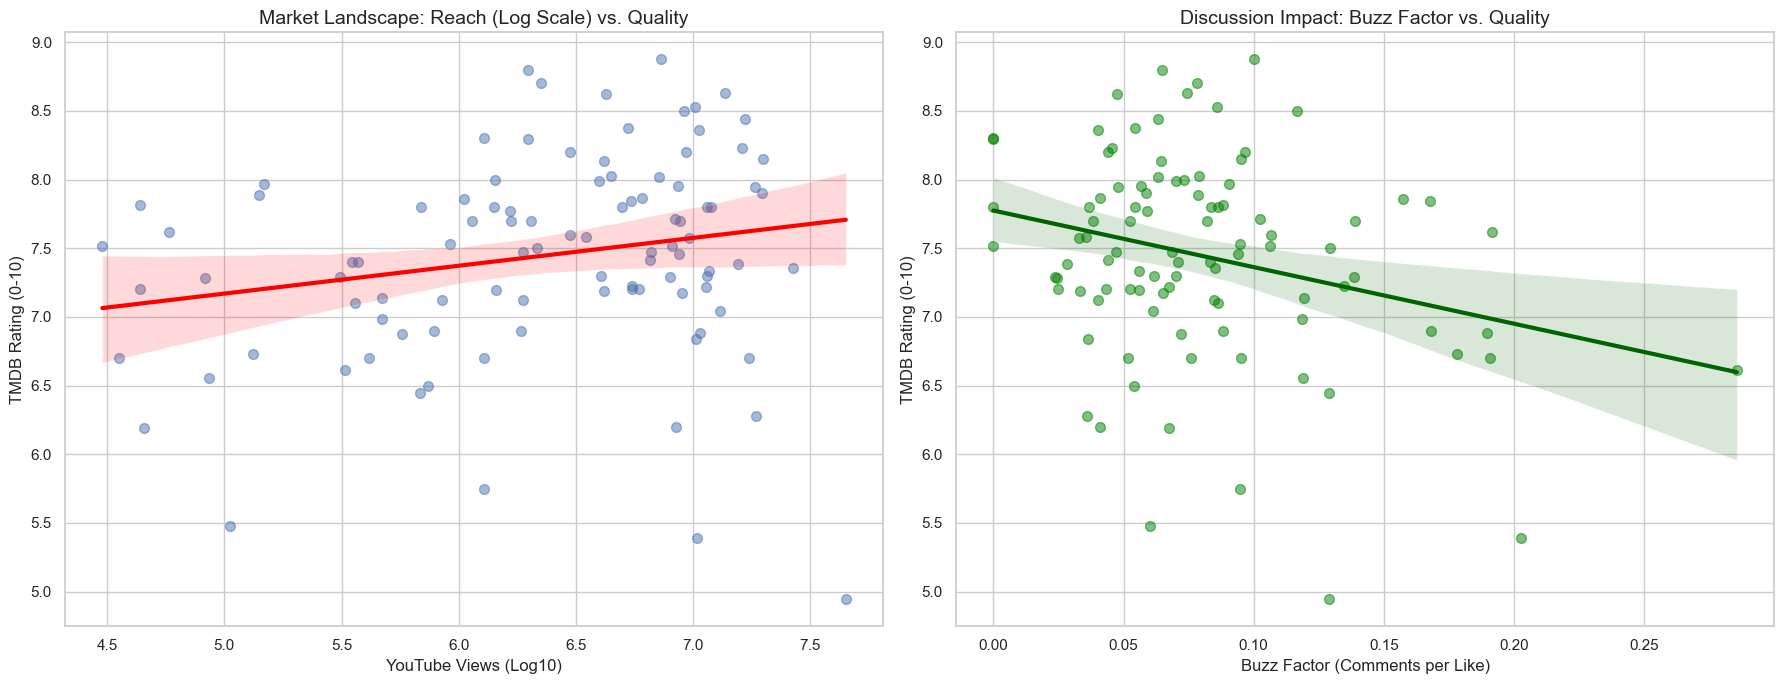

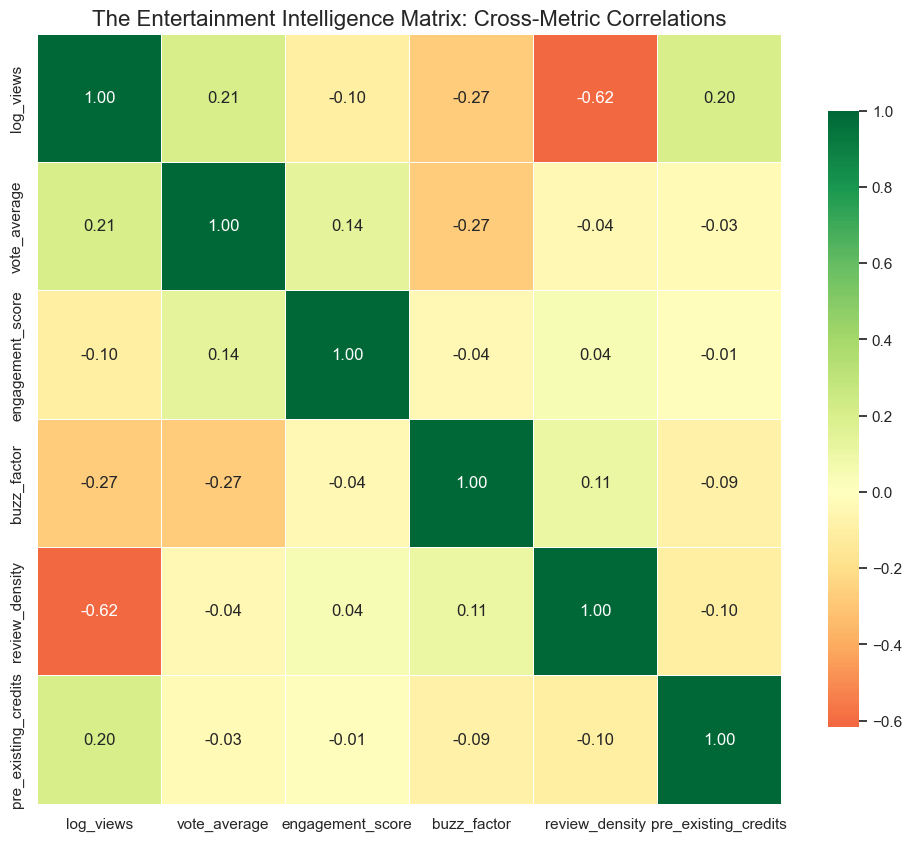

In [54]:

df_plot = df_master.replace([np.inf, -np.inf], np.nan).dropna(subset=['log_views', 'vote_average'])
df_plot = df_plot[df_plot.buzz_factor < 1]

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Log Views vs Rating 
sns.regplot(ax=axes[0], data=df_plot, x='log_views', y='vote_average', 
            scatter_kws={'alpha':0.5, 's':50}, line_kws={'color':'red', 'lw':3})
axes[0].set_title('Market Landscape: Reach (Log Scale) vs. Quality', fontsize=14)
axes[0].set_xlabel('YouTube Views (Log10)', fontsize=12)
axes[0].set_ylabel('TMDB Rating (0-10)', fontsize=12)

# Plot 2: Buzz Factor vs Rating
sns.regplot(ax=axes[1], data=df_plot, x='buzz_factor', y='vote_average', 
            scatter_kws={'alpha':0.5, 's':50, 'color':'green'}, line_kws={'color':'darkgreen', 'lw':3})
axes[1].set_title('Discussion Impact: Buzz Factor vs. Quality', fontsize=14)
axes[1].set_xlabel('Buzz Factor (Comments per Like)', fontsize=12)
axes[1].set_ylabel('TMDB Rating (0-10)', fontsize=12)

# # Add Labels to the 3 most interesting outliers on each plot
# for ax, col in zip(axes, ['log_views', 'buzz_factor']):
#     # Find the top 3 outliers for each metric
#     outliers = df_plot.nlargest(3, col)
#     for i, row in outliers.iterrows():
#         ax.text(row[col], row['vote_average'], row['name'], 
#                 fontsize=9, weight='bold', alpha=0.8)

plt.tight_layout()
plt.show()

# Plot 3: Correlation Heatmap (Refined)
plt.figure(figsize=(12, 10))
# We only correlate columns that provide 'Intelligence'
cols_to_corr = ['log_views', 'vote_average', 'engagement_score', 'buzz_factor', 'review_density', 'pre_existing_credits']
correlation = df_plot[cols_to_corr].corr()

sns.heatmap(correlation, annot=True, cmap='RdYlGn', center=0, fmt=".2f",
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('The Entertainment Intelligence Matrix: Cross-Metric Correlations', fontsize=16)
plt.show()

In [ ]:
sia = SentimentIntensityAnalyzer()
df_sent_analysis = df_master.copy()

with open('../data/youtube_comments_repository.json', 'r', encoding='utf-8') as f:
    comments_data = json.load(f)

# 3. Analyze each show
sentiment_results = []

for entry in comments_data:
    show_id = entry['show_id']
    comments = entry['comments']
    
    if not comments:
        sentiment_results.append({'show_id': show_id, 'sentiment_score': 0, 'pos_ratio': 0, 'neg_ratio': 0})
        continue
    
    # Calculate scores for all 50 comments
    scores = [sia.polarity_scores(c)['compound'] for c in comments]
    
    # Aggregate results
    avg_score = sum(scores) / len(scores)
    pos_count = len([s for s in scores if s > 0.05])
    neg_count = len([s for s in scores if s < -0.05])
    
    sentiment_results.append({
        'show_id': show_id,
        'sentiment_score': avg_score, # Scale of -1 (Hate) to +1 (Love)
        'pos_ratio': pos_count / len(comments),
        'neg_ratio': neg_count / len(comments)
    })

df_sentiment = pd.DataFrame(sentiment_results)
df_sent_analysis = pd.merge(df_sent_analysis, df_sentiment, on='show_id', how='left')

print("Sentiment Analysis Complete!")
df_sent_analysis[['name', 'sentiment_score', 'pos_ratio', 'neg_ratio']].sort_values(by='sentiment_score', ascending=False).head()

Sentiment Analysis Complete!


,name,sentiment_score,pos_ratio,neg_ratio
88,Stick,0.446740,0.740000,0.100000
41,RIPLEY,0.355134,0.680000,0.140000
97,Duster,0.326111,0.607143,0.142857
80,Palm Royale,0.324956,0.540000,0.080000
23,Bad Monkey,0.304354,0.540000,0.180000


In [14]:
df_master = df_sent_analysis.copy()

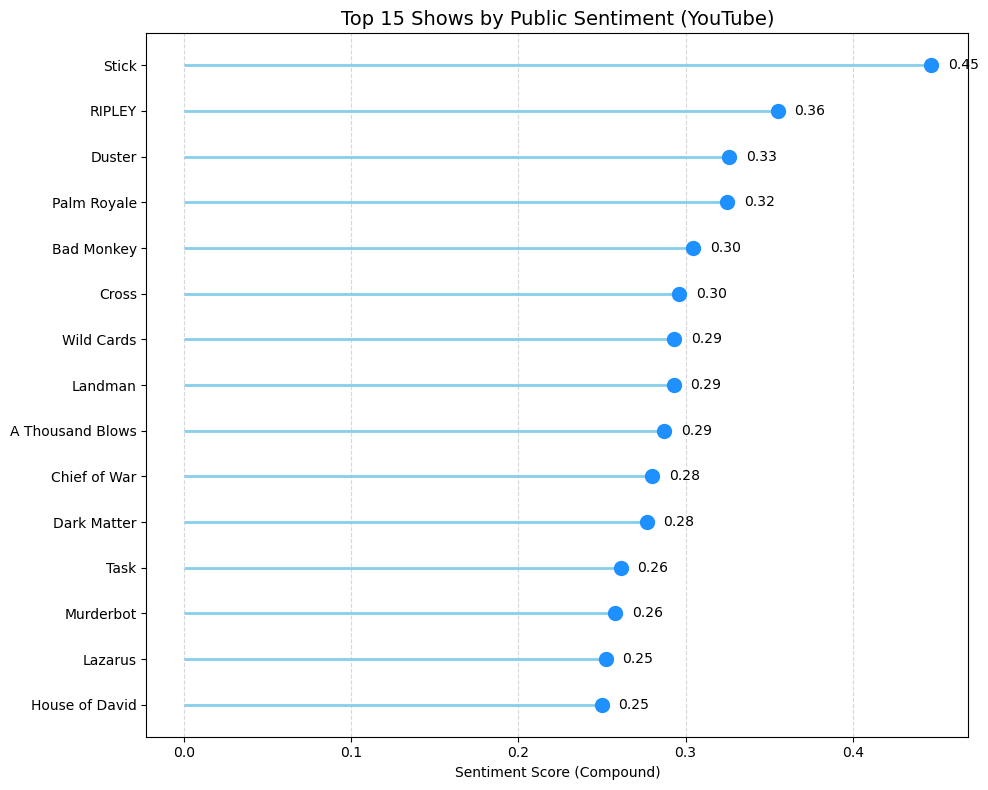

In [15]:
# Select top 15 by sentiment
top_sentiment = df_master.nlargest(15, 'sentiment_score').sort_values('sentiment_score')

plt.figure(figsize=(10, 8))
plt.hlines(y=top_sentiment['name'], xmin=0, xmax=top_sentiment['sentiment_score'], color='skyblue', linewidth=2)
plt.plot(top_sentiment['sentiment_score'], top_sentiment['name'], "o", markersize=10, color='dodgerblue')

# Add values at the end of the lollipops
for i, row in top_sentiment.iterrows():
    plt.text(row['sentiment_score'] + 0.01, row['name'], f"{row['sentiment_score']:.2f}", va='center')

plt.title('Top 15 Shows by Public Sentiment (YouTube)', fontsize=14)
plt.xlabel('Sentiment Score (Compound)')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

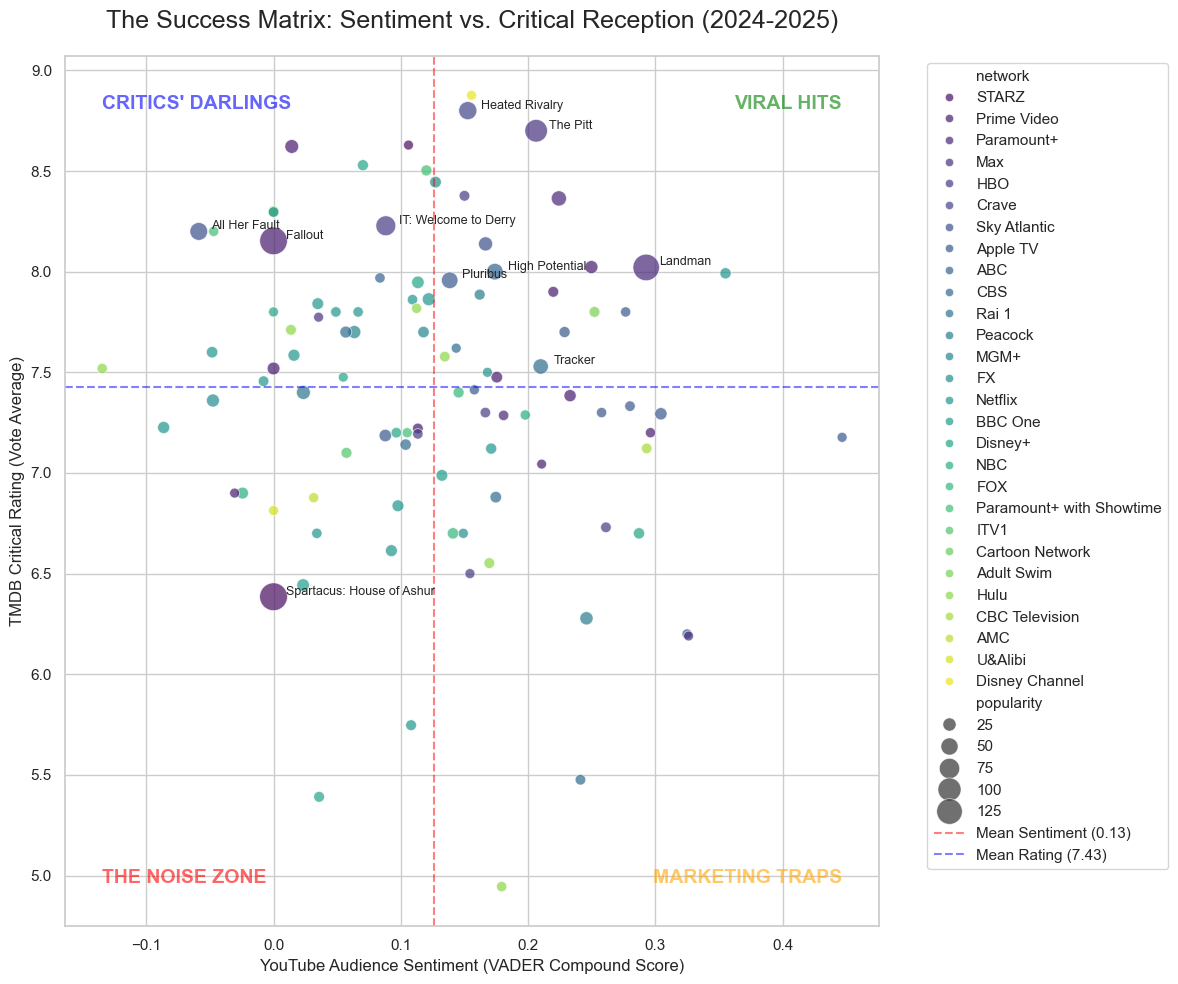

In [64]:
# 1. Calculate the mean values for the quadrant lines
mean_sentiment = df_master['sentiment_score'].mean()
mean_rating = df_master['vote_average'].mean()

# 2. Set the aesthetic style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 10))

# 3. Create the scatter plot
# Color shows by network or genre to add more depth
scatter = sns.scatterplot(
    data=df_master, 
    x='sentiment_score', 
    y='vote_average', 
    hue='network', 
    size='popularity', 
    sizes=(50, 400), 
    alpha=0.7, 
    palette='viridis'
)

# 4. Add the quadrant midlines
plt.axvline(x=mean_sentiment, color='red', linestyle='--', alpha=0.5, label=f'Mean Sentiment ({mean_sentiment:.2f})')
plt.axhline(y=mean_rating, color='blue', linestyle='--', alpha=0.5, label=f'Mean Rating ({mean_rating:.2f})')

# 5. Annotate the Quadrants
plt.text(df_master['sentiment_score'].max(), df_master['vote_average'].max(), "VIRAL HITS", 
         fontsize=14, fontweight='bold', ha='right', va='top', color='green', alpha=0.6)

plt.text(df_master['sentiment_score'].min(), df_master['vote_average'].max(), "CRITICS' DARLINGS", 
         fontsize=14, fontweight='bold', ha='left', va='top', color='blue', alpha=0.6)

plt.text(df_master['sentiment_score'].max(), df_master['vote_average'].min(), "MARKETING TRAPS", 
         fontsize=14, fontweight='bold', ha='right', va='bottom', color='orange', alpha=0.6)

plt.text(df_master['sentiment_score'].min(), df_master['vote_average'].min(), "THE NOISE ZONE", 
         fontsize=14, fontweight='bold', ha='left', va='bottom', color='red', alpha=0.6)

# 6. Label outliers (Top 10 shows)
top_shows = df_master.nlargest(10, 'popularity')
for i, row in top_shows.iterrows():
    plt.text(row['sentiment_score']+0.01, row['vote_average']+0.01, row['name'], fontsize=9)

# 7. Final Formatting
plt.title('The Success Matrix: Sentiment vs. Critical Reception (2024-2025)', fontsize=18, pad=20)
plt.xlabel('YouTube Audience Sentiment (VADER Compound Score)', fontsize=12)
plt.ylabel('TMDB Critical Rating (Vote Average)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the figure for your portfolio
plt.savefig('success_matrix.png', dpi=300)
plt.show()

In [18]:
import plotly.express as px

# 1. Create the interactive scatter plot
fig = px.scatter(
    df_master, 
    x="sentiment_score", 
    y="vote_average",
    hover_name="name",            # Display show name on hover
    color="network",               # Color by platform
    size="popularity",             # Bubble size reflects reach
    # text="name",                   # Optional: static labels (can get crowded)
    labels={
        "sentiment_score": "Audience Sentiment (VADER)",
        "vote_average": "TMDB Critical Rating"
    },
    title="The Success Matrix: Sentiment VS Rating"
)

# 2. Add quadrant lines (optional but recommended)
fig.add_hline(y=df_master['vote_average'].mean(), line_dash="dash", line_color="blue", opacity=0.5)
fig.add_vline(x=df_master['sentiment_score'].mean(), line_dash="dash", line_color="red", opacity=0.5)

# 3. Export as a standalone HTML file
fig.write_html("../images/interactive_matrix.html")